# Lectura del Motor Por Serial

Mensaje enviado: 100
Leyendo datos durante 3 segundos...
[0.000 s] RPM: 23.63
[0.001 s] RPM: 0.0
[0.001 s] RPM: 0.0
[0.002 s] RPM: 0.0
[0.002 s] RPM: 0.0
[0.002 s] RPM: 0.0
[0.004 s] RPM: 0.0
[0.004 s] RPM: 0.0
[0.005 s] RPM: 23.33
[0.005 s] RPM: 0.0
[0.006 s] RPM: 0.0
[0.006 s] RPM: 0.0
[0.007 s] RPM: 0.0
[0.007 s] RPM: 0.0
[0.008 s] RPM: 0.0
[0.008 s] RPM: 0.0
[0.008 s] RPM: 0.0
[0.008 s] RPM: 0.0
[0.009 s] RPM: 0.0
[0.009 s] RPM: 0.0
[0.010 s] RPM: 0.0
[0.010 s] RPM: 0.0
[0.011 s] RPM: 23.33
[0.011 s] RPM: 0.0
[0.012 s] RPM: 0.0
[0.013 s] RPM: 0.0
[0.014 s] RPM: 23.7
[0.015 s] RPM: 0.0
[0.015 s] RPM: 0.0
[0.016 s] RPM: 23.7
[0.017 s] RPM: 0.0
[0.017 s] RPM: 0.0
[0.018 s] RPM: 0.0
[0.018 s] RPM: 0.0
[0.018 s] RPM: -24.21
[0.019 s] RPM: 0.0
[0.020 s] RPM: 23.97
[0.020 s] RPM: 0.0
[0.021 s] RPM: 10.46
[0.021 s] RPM: 0.0
[0.022 s] RPM: 0.0
[0.022 s] RPM: 0.0
[0.022 s] RPM: 0.0
[0.022 s] RPM: 0.0
[0.023 s] RPM: -23.33
[0.023 s] RPM: 0.0
[0.024 s] RPM: -23.66
[0.025 s] RPM: 0.0
[0.026 s] 

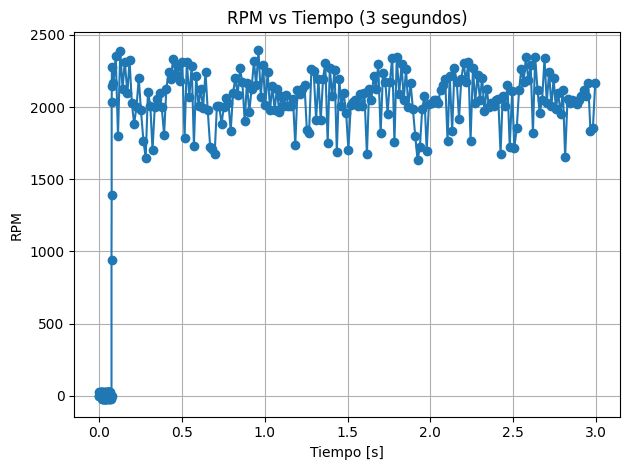

In [70]:
import serial
import time
import re
import matplotlib.pyplot as plt

# Configuración
puerto = 'COM7'
baudios = 115200
pwm = 100
rpm_lista = []
tiempos = []

try:
    ser = serial.Serial(puerto, baudios, timeout=0)
    time.sleep(2)  # Esperar a que el dispositivo esté listo

    # Enviar PWM como "100\n"
    mensaje = f"{pwm}\n"
    ser.write(mensaje.encode())
    print(f"Mensaje enviado: {mensaje.strip()}")

    print("Leyendo datos durante 3 segundos...")

    t_inicio = time.time()
    while time.time() - t_inicio < 3:
        #ser.reset_input_buffer()  # Vaciar búfer antes de leer
        #time.sleep(0.001)

        linea = ser.readline().decode(errors='ignore').strip()
        if linea:
            match = re.search(r'RPM:\s*(-?[0-9.]+)', linea)

            if match:
                rpm = float(match.group(1))
                tiempo_relativo = time.time() - t_inicio
                rpm_lista.append(rpm)
                tiempos.append(tiempo_relativo)
                print(f"[{tiempo_relativo:.3f} s] RPM: {rpm}")

except serial.SerialException as e:
    print(f"Error al abrir el puerto: {e}")

except KeyboardInterrupt:
    print("\nLectura interrumpida por el usuario.")

finally:
    if 'ser' in locals() and ser.is_open:
        ser.close()
        print("Puerto cerrado.")

# Graficar resultados
if rpm_lista:
    plt.figure()
    plt.plot(tiempos, rpm_lista, marker='o')
    plt.title("RPM vs Tiempo (3 segundos)")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("RPM")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No se capturaron datos de RPM.")


# Creacion Modelo Segundo Orden

Modelo ajustado:
 K = 2047.0508, wn = 11.4227, zeta = 0.5723


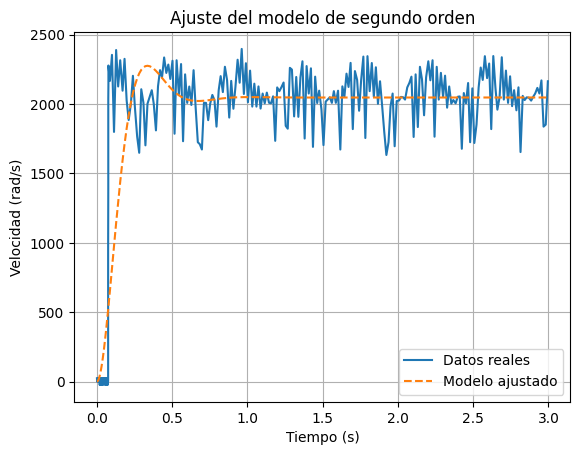

In [71]:
import numpy as np
from scipy.optimize import curve_fit

def second_order_step(t, K, wn, zeta):
    t=np.array(t)
    wd = wn * np.sqrt(1 - zeta**2)
    response = K * (1 - np.exp(-zeta*wn*t) * (
        np.cos(wd*t) + (zeta*wn/wd)*np.sin(wd*t)
    ))
    return response

# Estimar parámetros iniciales (puedes afinar)
K0 = rpm_lista[-1]
wn0 = 10
zeta0 = 0.7
p0 = [K0, wn0, zeta0]

# Ajustar curva
params, _ = curve_fit(second_order_step, tiempos, rpm_lista, p0)
K_est, wn_est, zeta_est = params
print(f"Modelo ajustado:\n K = {K_est:.4f}, wn = {wn_est:.4f}, zeta = {zeta_est:.4f}")

# Graficar resultado
y_fit = second_order_step(tiempos, *params)
plt.plot(tiempos, rpm_lista, label='Datos reales')
plt.plot(tiempos, y_fit, '--', label='Modelo ajustado')
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (rad/s)")
plt.title("Ajuste del modelo de segundo orden")
plt.grid(True)
plt.legend()
plt.show()

# Sistema en funcion de tranferencia

G(s) estimada:
<TransferFunction>: sys[38]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


      2.671e+05
---------------------
s^2 + 13.07 s + 130.5



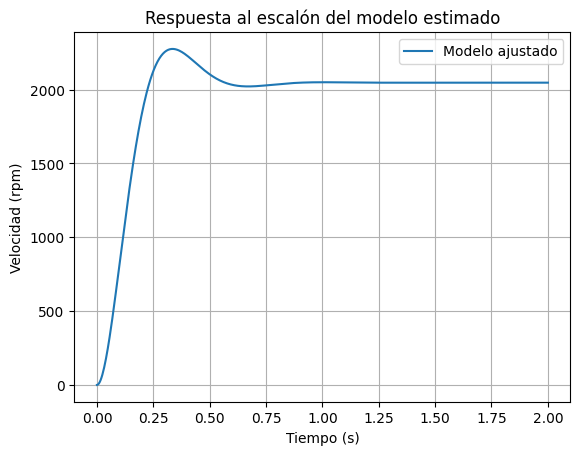

In [ ]:
from control import TransferFunction
import control as ctrl

# Numerador y denominador según fórmula estándar
K_est, wn_est, zeta_est
num = [K_est * wn_est**2]
den = [1, 2*zeta_est*wn_est, wn_est**2]

# Crear la función de transferencia
G_fit = TransferFunction(num, den)

# Mostrar la función de transferencia
print("G(s) estimada:")
print(G_fit)
t = np.linspace(0, 2, 500)
t_out, y_out = ctrl.step_response(G_fit, T=t)

plt.plot(t_out, y_out, label='Modelo ajustado')
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (rpm)")
plt.title("Respuesta al escalón del modelo estimado")
plt.grid(True)
plt.legend()
plt.show()


# Polos deseados

In [73]:
import numpy as np

# Requisitos
Mp = 0.20             # Overshoot máximo (20%)
ts = 5                # Tiempo de estabilización máximo (5 segundos)

# Cálculo de zeta deseado
lnMp = np.log(Mp)
zeta_d = -lnMp / np.sqrt(np.pi**2 + lnMp**2)

# Cálculo de frecuencia natural deseada
wn_d = 4 / (zeta_d * ts)

# Polos deseados
real_part = -zeta_d * wn_d
imag_part = wn_d * np.sqrt(1 - zeta_d**2)

# Polos conjugados
p1 = complex(real_part, imag_part)
p2 = complex(real_part, -imag_part)

#print(f"ζ_d: {zeta_d:.4f}, ω_n^d: {wn_d:.4f}")
print(f"Polos deseados: {p1:.4f}, {p2:.4f}")


Polos deseados: -0.8000+1.5616j, -0.8000-1.5616j


# Compenzador de adelanto

# Fase de la planta

In [74]:
import numpy as np

# Polos deseados
s_d = complex(-0.8, 1.58)

# Planta: polos del denominador
p1 = complex(-15.325, 15.327)  # ±j raíz(wn^2 - (zeta*wn)^2)
p2 = complex(-15.325, -15.327)

# Fase total de la planta en s_d
angle_G = np.angle(s_d - p1) + np.angle(s_d - p2)
angle_G_deg = np.degrees(angle_G)
print(f"Fase de G(s) en s_d: {angle_G_deg:.2f}°")


Fase de G(s) en s_d: 5.91°


# Fase a Aportar

In [75]:
# Fase faltante
angle_needed_deg = -180 - angle_G_deg
print(f"Fase que debe aportar el compensador: {angle_needed_deg:.2f}°")


Fase que debe aportar el compensador: -185.91°


In [76]:
# Valor inicial para el cero
z_c = -0.1  # pruebo un cero cercano al origen

# Calculo el ángulo que hace (s_d - z_c)
phi_z = np.angle(s_d - z_c)

# Ángulo necesario en radianes
phi_c = np.radians(angle_needed_deg)

# El ángulo que debe generar el polo: phi_p = phi_z - phi_c
phi_p = phi_z - phi_c

# Coordenadas del polo en el plano complejo
# Queremos resolver (s_d - p_c) con ese ángulo → despejamos p_c

# Esto implica:
# s_d - p_c = |r| * e^(j*phi_p)  ⇒  p_c = s_d - vector con ángulo phi_p

r = 1  # módulo arbitrario (luego se ajusta el K)

p_c = s_d - r * np.exp(1j * phi_p)

print(f"Colocamos el cero del compensador en z_c = {z_c}")
print(f"Polo del compensador p_c = {p_c.real:.4f}")


Colocamos el cero del compensador en z_c = -0.1
Polo del compensador p_c = -1.2971


# Muestra del lugar geometrico de la raiz

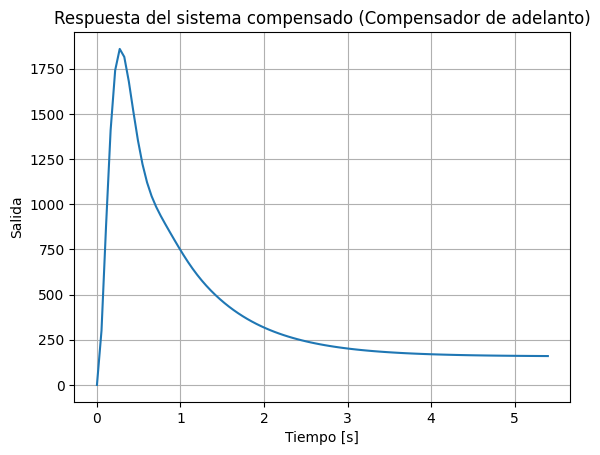

In [78]:
from scipy import signal

# Transferencias
num_G = num
den_G = den

# Compensador
num_C = [1, -z_c]
den_C = [1, -p_c.real]  # uso parte real porque el compensador debe ser real

# Sistema compensado
num_total = np.polymul(num_G, num_C)
den_total = np.polymul(den_G, den_C)

sys = signal.TransferFunction(num_total, den_total)

# Simulación
import matplotlib.pyplot as plt

t, y = signal.step(sys)
plt.plot(t, y)
plt.title("Respuesta del sistema compensado (Compensador de adelanto)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Salida")
plt.grid()
plt.show()


# Calculo Ganancia

In [83]:
# Polos deseados
s_d = complex(-0.8, 1.58)


# Evaluar G(s_d)
G_s_d = np.polyval(num_G, s_d) / np.polyval(den_G, s_d)

# Compensador C(s): cero y polo
z_c = -0.1
# El polo lo calculamos antes
phi_z = np.angle(s_d - z_c)
phi_c = np.radians(-180 - np.angle(s_d - p1) - np.angle(s_d - p2))
phi_p = phi_z - phi_c
p_c = s_d - 1 * np.exp(1j * phi_p)
p_c = p_c.real  # aseguramos compensador real

# Evaluar el módulo del compensador en s_d
C_mag = abs((s_d - z_c) / (s_d - p_c))

# Ganancia total para que |L(s_d)| = 1
K_c = 1 / (abs(G_s_d) * C_mag)

print(f"Ganancia compensadora K_c: {K_c:.4f}")


Ganancia compensadora K_c: 0.0004


# Sistema Compensado

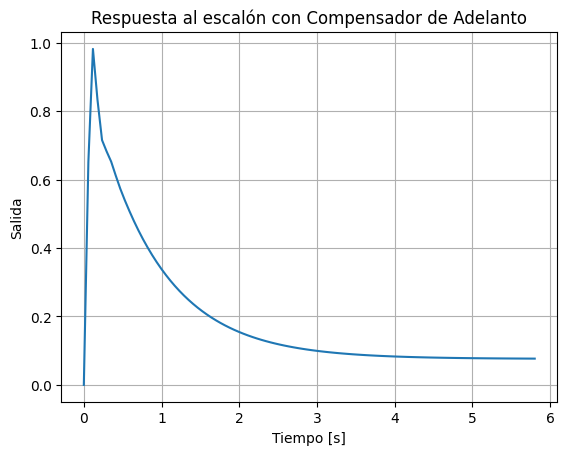

In [84]:
from scipy import signal

# Compensador
num_C = [1, -z_c]
den_C = [1, -p_c]

# Sistema compensado
num_total = K_c * np.polymul(num_G, num_C)
den_total = np.polymul(den_G, den_C)

sys_comp = signal.TransferFunction(num_total, den_total)

# Simulación
import matplotlib.pyplot as plt

t, y = signal.step(sys_comp)
plt.plot(t, y)
plt.title("Respuesta al escalón con Compensador de Adelanto")
plt.xlabel("Tiempo [s]")
plt.ylabel("Salida")
plt.grid(True)
plt.show()


# Compenzador de atrazo

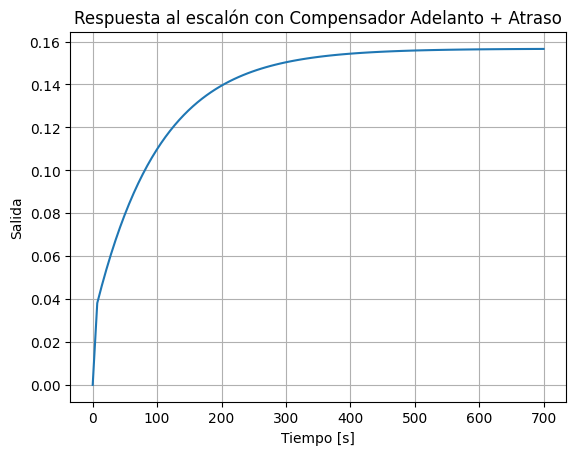

In [85]:
# Cero y polo del atraso

from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
z_a = 0.1
p_a = 0.01
# Compensador de adelanto (de antes)
z_c = -0.1
p_c = -4.5  # ejemplo, puedes ajustar
K_c = 0.00034  # ganancia que obtuviste antes

# Compensador de atraso
z_a = 0.1
p_a = 0.01



# Armado total: C_atraso * C_adelanto * G
num_C_total = np.polymul([1, -z_c], [1, z_a])
den_C_total = np.polymul([1, -p_c], [1, p_a])

num_total = K_c * np.polymul(num_G, num_C_total)
den_total = np.polymul(den_G, den_C_total)

# Sistema compensado completo
sys_total = signal.TransferFunction(num_total, den_total)

# Simulación
t, y = signal.step(sys_total)
plt.plot(t, y)
plt.title("Respuesta al escalón con Compensador Adelanto + Atraso")
plt.xlabel("Tiempo [s]")
plt.ylabel("Salida")
plt.grid(True)
plt.show()
